In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


In [112]:
%matplotlib inline


In [113]:
data = pd.read_csv(r'C:\Users\keyan\Downloads\HH NG spot price MONTH.csv')

data['Date'] = pd.to_datetime(data['Date'], format='%b-%y')
data.set_index('Date', inplace=True)

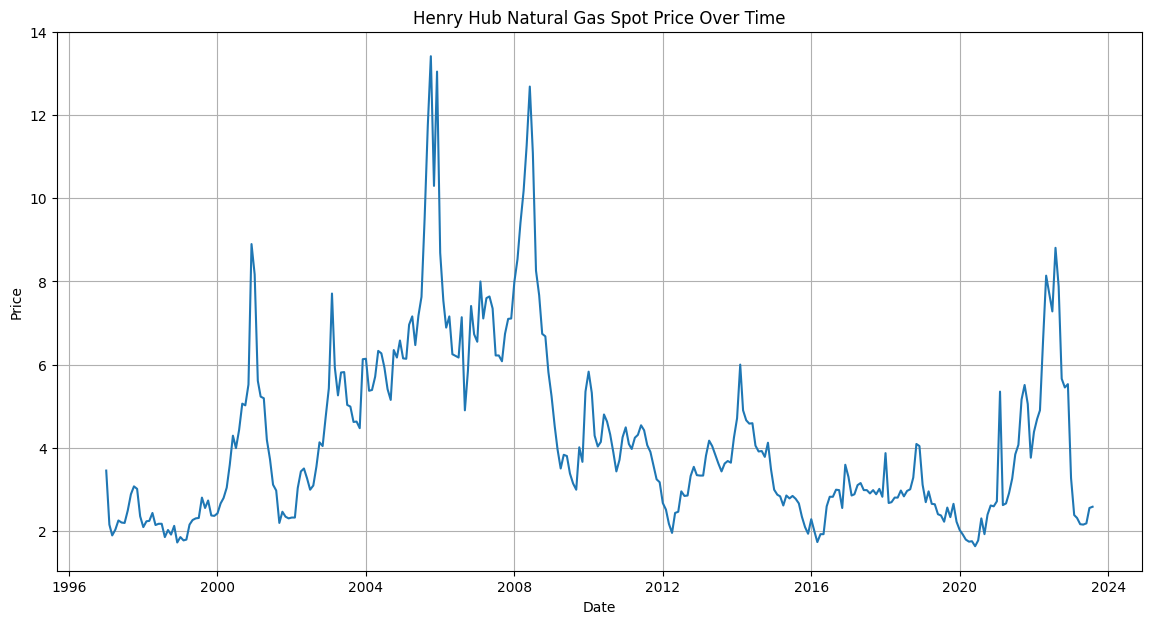

In [114]:
# Plot HHNG Price Data
plt.figure(figsize=(14,7))
plt.plot(data['Henry Hub Natural Gas Spot Price '])
data.rename(columns={'Henry Hub Natural Gas Spot Price ': 'Price'}, inplace=True)
plt.title('Henry Hub Natural Gas Spot Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


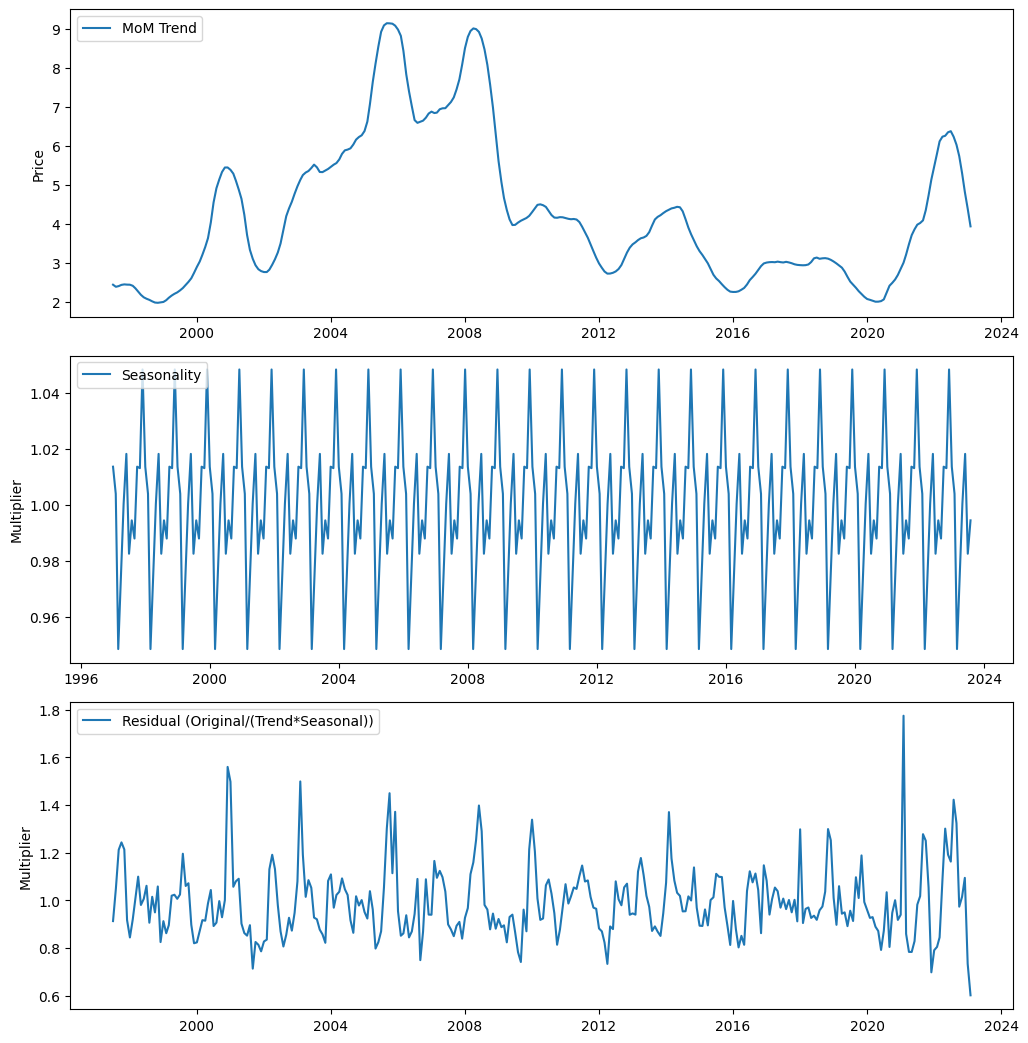

In [115]:
# Decompose seasonal and long term trend using multiplicative model
decomposition_multiplicative = seasonal_decompose(data['Price'], model='multiplicative')
trend_multiplicative = decomposition_multiplicative.trend
seasonal_multiplicative = decomposition_multiplicative.seasonal
residual_multiplicative = decomposition_multiplicative.resid

plt.figure(figsize=(20,14))

plt.subplot(423)
plt.plot(trend_multiplicative, label='MoM Trend')
plt.ylabel('Price')
plt.legend(loc='upper left')

plt.subplot(425)
plt.plot(seasonal_multiplicative, label='Seasonality')
plt.ylabel('Multiplier')
plt.legend(loc='upper left')

plt.subplot(427)
plt.plot(residual_multiplicative, label='Residual (Original/(Trend*Seasonal))')
plt.ylabel('Multiplier')
plt.legend(loc='upper left')

plt.tight_layout()

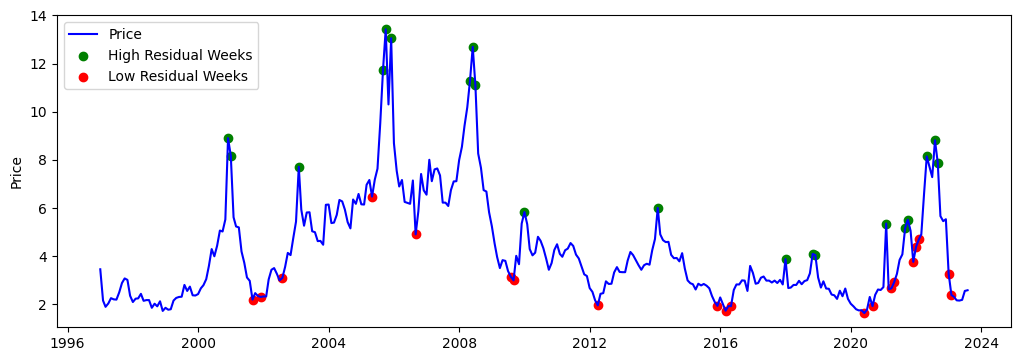

In [116]:
# find most extreme residual weeks
highest_residual_dates = residual_multiplicative.sort_values(ascending=False).head(20).index
highest_residual_values = residual_multiplicative.sort_values(ascending=False).head(20).values

lowest_residual_dates = residual_multiplicative.sort_values(ascending=True).head(20).index
lowest_residual_values = residual_multiplicative.sort_values(ascending=True).head(20).values

plt.figure(figsize=(20,14))

# plot price with extreme price residuals highlighted
plt.subplot(421)
plt.plot(data['Price'], label='Price', color='blue')
plt.scatter(highest_residual_dates, data['Price'].loc[highest_residual_dates], color='green', label='High Residual Weeks')
plt.scatter(lowest_residual_dates, data['Price'].loc[lowest_residual_dates], color='red', label='Low Residual Weeks')
plt.ylabel('Price')
plt.legend(loc='upper left')

plt.tight_layout()



In [117]:
# reprocess HHG data
hhg_df = pd.read_csv(r'C:\Users\keyan\Downloads\HH NG spot price MONTH.csv')
hhg_df.columns = hhg_df.columns.str.strip()
hhg_df = hhg_df.rename(columns={'Date': 'Date_HHG', 'Henry Hub Natural Gas Spot Price': 'HHG_Price'})
hhg_df['Date_HHG'] = pd.to_datetime(hhg_df['Date_HHG'], format='%b-%y')

# Read and preprocess Temperature data
temp_df = pd.read_csv(r'C:\Users\keyan\Downloads\monthly (1).csv')
temp_df = temp_df.rename(columns={'Date': 'Date_Temp', 'Mean': 'Temp_Anomaly'})
temp_df['Date_Temp'] = pd.to_datetime(temp_df['Date_Temp'], format='%Y-%m')

# Filter data to include only from 1995 to present
hhg_df = hhg_df[hhg_df['Date_HHG'] >= '1995-01-01']
temp_df = temp_df[temp_df['Date_Temp'] >= '1995-01-01']

# Merge datasets on Date
merged_df = pd.merge(hhg_df, temp_df, left_on='Date_HHG', right_on='Date_Temp', how='inner')

# Filter merged data to make sure it starts from 1995
merged_df = merged_df[merged_df['Date_HHG'] >= '1995-01-01']
merged_df = merged_df[merged_df['Date_Temp'] >= '1995-01-01']

# Calculate residuals for HHG prices
merged_df['Residual'] = merged_df['HHG_Price'] - merged_df['HHG_Price'].mean()


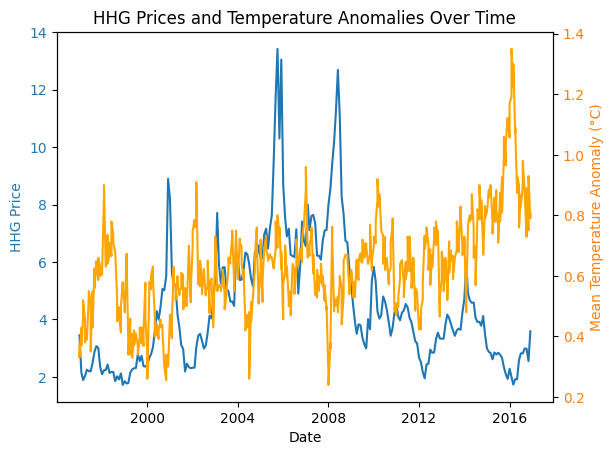

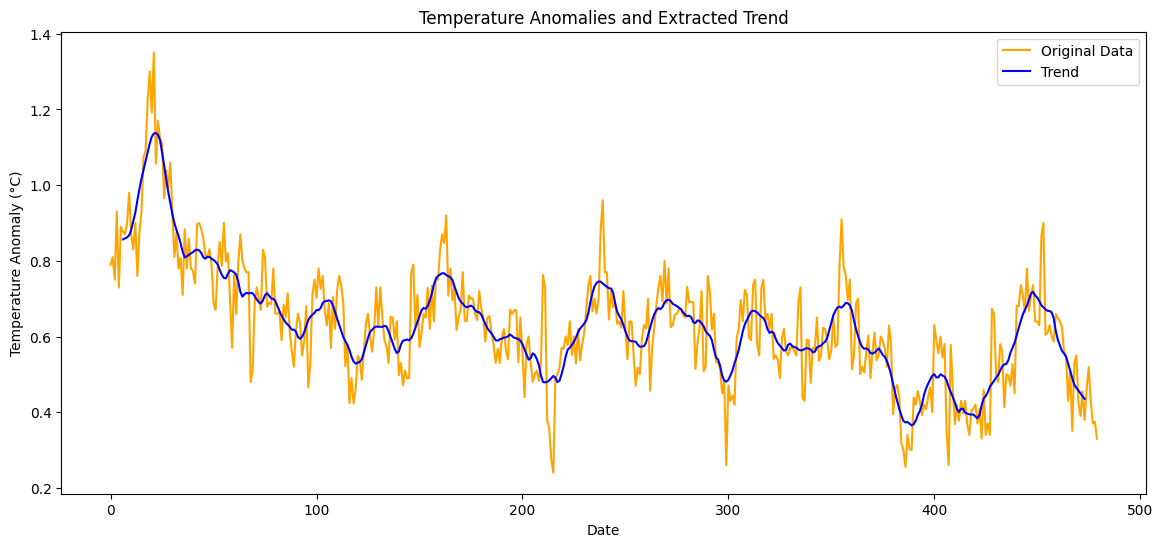

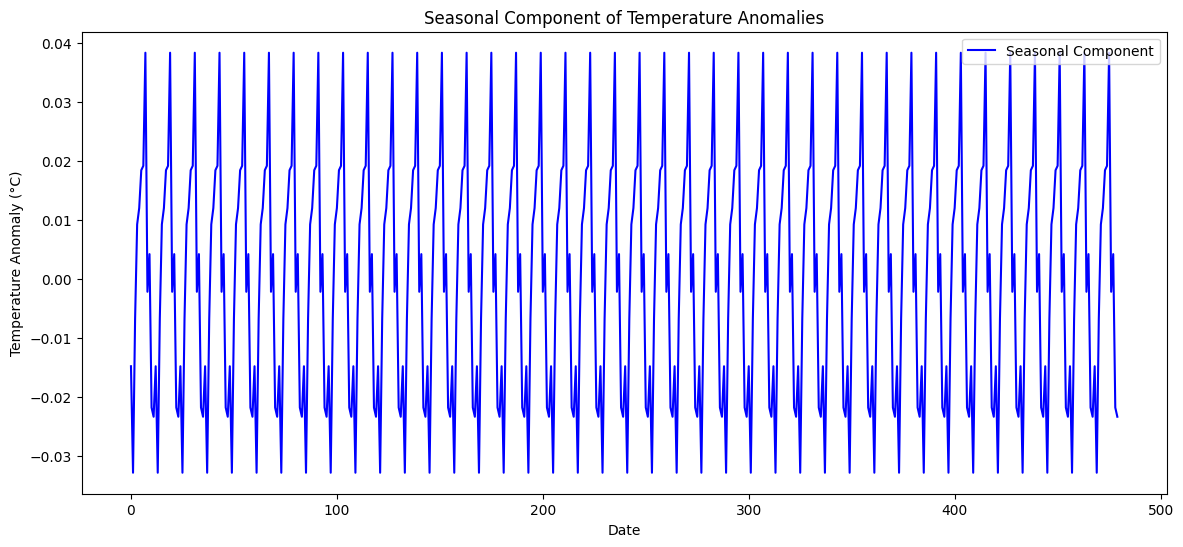

In [118]:
# Identify high and low residual points
high_residual_points = merged_df[merged_df['Residual'] > merged_df['Residual'].quantile(0.95)]
low_residual_points = merged_df[merged_df['Residual'] < merged_df['Residual'].quantile(0.05)]

# Create the plot
fig, ax1 = plt.subplots()

# Plot HHG prices
ax1.set_xlabel('Date')
ax1.set_ylabel('HHG Price', color='tab:blue')
ax1.plot(merged_df['Date_HHG'], merged_df['HHG_Price'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Highlight high and low residual points
#ax1.scatter(high_residual_points['Date_HHG'], high_residual_points['HHG_Price'], color='red')
#ax1.scatter(low_residual_points['Date_HHG'], low_residual_points['HHG_Price'], color='green')

# Create a second y-axis for temperature anomalies
ax2 = ax1.twinx()
ax2.set_ylabel('Mean Temperature Anomaly (°C)', color='tab:orange')
ax2.plot(merged_df['Date_HHG'], merged_df['Temp_Anomaly'], color='orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Show the plot
plt.title('HHG Prices and Temperature Anomalies Over Time')
plt.show()

# Correcting the parameter name from 'freq' to 'period' for seasonal decomposition
decomposition = seasonal_decompose(temp_df['Temp_Anomaly'], period=12)  # Using monthly frequency

# Extracting the trend component
trend = decomposition.trend.dropna()

# Plotting the original data along with the extracted trend
plt.figure(figsize=(14, 6))
plt.plot(temp_df['Temp_Anomaly'], label='Original Data', color='orange')
plt.plot(trend, label='Trend', color='blue')
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Temperature Anomalies and Extracted Trend')
plt.legend()
plt.show()

seasonal = decomposition.seasonal.dropna()

plt.figure(figsize=(14, 6))
plt.plot(seasonal, label='Seasonal Component', color='blue')
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Seasonal Component of Temperature Anomalies')
plt.legend()
plt.show()


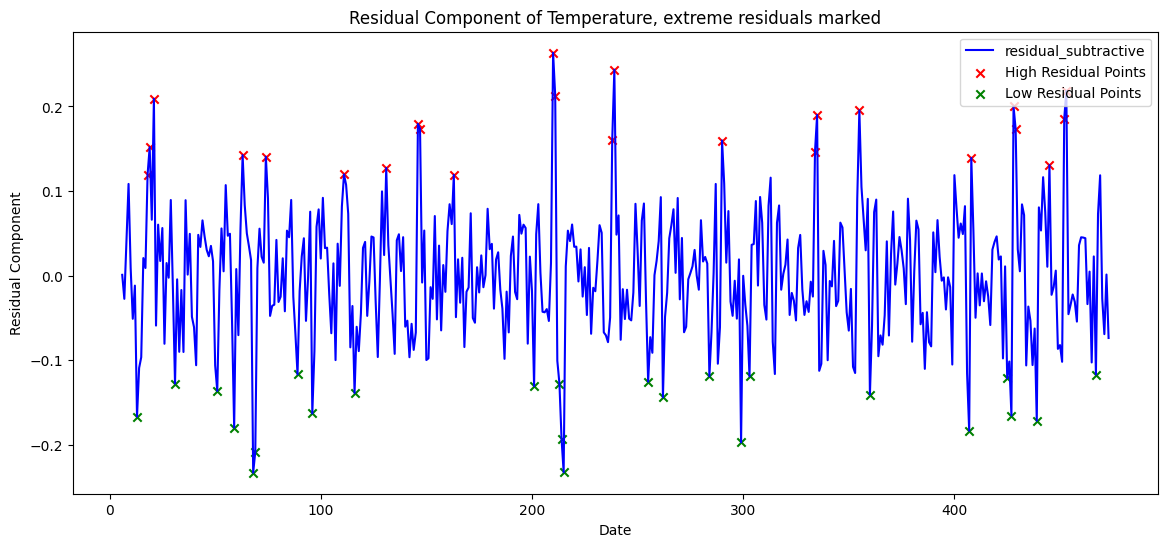

<Figure size 640x480 with 0 Axes>

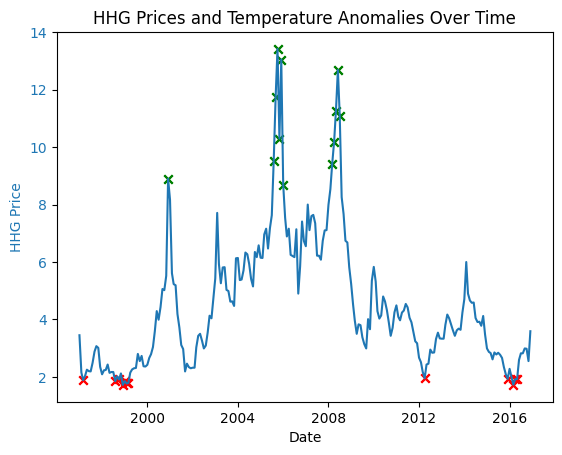

In [119]:
residual_subtract = temp_df['Temp_Anomaly'].loc[seasonal.index] - (seasonal + trend)

high_residual_points_subtract = residual_subtract[residual_subtract > residual_subtract.quantile(0.95)]
low_residual_points_subtract = residual_subtract[residual_subtract < residual_subtract.quantile(0.05)]

plt.figure(figsize=(14, 6))
plt.plot(residual_subtract, label='residual_subtractive', color='blue')
plt.scatter(high_residual_points_subtract.index, high_residual_points_subtract, color='red', label='High Residual Points',marker='x')
plt.scatter(low_residual_points_subtract.index, low_residual_points_subtract, color='green', label='Low Residual Points',marker='x')
plt.xlabel('Date')
plt.ylabel('Residual Component')
plt.title('Residual Component of Temperature, extreme residuals marked')
plt.legend()
plt.show()

plt.tight_layout()

hhg_df = hhg_df[hhg_df['Date_HHG'] >= '1995-01-01']
temp_df = temp_df[temp_df['Date_Temp'] >= '1995-01-01']
merged_df = pd.merge(hhg_df, temp_df, left_on='Date_HHG', right_on='Date_Temp', how='inner')

merged_df = merged_df[merged_df['Date_HHG'] >= '1995-01-01']
merged_df = merged_df[merged_df['Date_Temp'] >= '1995-01-01']
merged_df['Residual'] = merged_df['HHG_Price'] - merged_df['HHG_Price'].mean()

# temp residual points
high_residual_points = merged_df[merged_df['Residual'] > merged_df['Residual'].quantile(0.95)]
low_residual_points = merged_df[merged_df['Residual'] < merged_df['Residual'].quantile(0.05)]

fig, ax1 = plt.subplots()

# HHG and temp residual plot
ax1.set_xlabel('Date')
ax1.set_ylabel('HHG Price', color='tab:blue')
ax1.plot(merged_df['Date_HHG'], merged_df['HHG_Price'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.scatter(high_residual_points['Date_HHG'], high_residual_points['HHG_Price'], color='green',marker='x')
ax1.scatter(low_residual_points['Date_HHG'], low_residual_points['HHG_Price'], color='red',marker='x')
plt.title('HHG Prices and Temperature Anomalies Over Time')
plt.show()